# **Joint Angle prediction from IMU data using deep learning.**

As a part of the Article: Gait Speed and Task-Specificity in Predicting Lower-Limb Kinematics: A Deep Learning Approach Using Inertial Sensors

DOI: (Will be added)

# Author: Vaibhav R. Shah and Philippe C. Dixon

We recomand you run on google colaboratory.

In [1]:
# Need to downgrade tensorflow library to to 2.14.0 for with trained model loading
!pip install tensorflow==2.14.0


## Import required libraries

In [2]:
import tensorflow as tf
import keras
import sys
import numpy as np
import pandas as pd
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.14.0
Keras version: 2.14.0


## Mount drive to access python sripts (GaitLab2Go.py)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# import important scripts from GaitLab2Go.py
sys.path.append('/content/drive/MyDrive/Joint-Angle-prediction')
import GaitLab2Go as GL2G

## Processing data

In [5]:
lab=GL2G.data_processing()
fld='/content/drive/MyDrive/Joint-Angle-prediction/data'
ext='.zoo'

Converting .zoo files to .pkl files (Compatible with GaitLab2Go library)

In [6]:
# Get the IMU variables from lab's variables zoo and store in 'variables'
variables = lab.variables_zoo_IMU()

# Remove the last 18 variables from the list
#variables = variables[:-18]

# Find files in the specified folder 'fld' with the extension specified in 'ext'
fl = lab.find_files(path=fld, ext=ext)

# Convert files from Zoo format to dictionary format using 'variables' and store the result
lab.zoo2dictionary(fl, variables)

# Set file extension to '.pkl' for further processing
ext = '.pkl'

# Find files again in 'fld' directory, but now with the new extension '.pkl'
fl = lab.find_files(path=fld, ext=ext)

# Specify the list of subjects for processing (in this case, a single subject 'pp054')
subject_list = ['pp054']

# List of files to process (found previously with the '.pkl' extension)
file_list = fl

# Process the specified subject files using the subject and file lists
print(subject_list)
print(file_list)
lab.process_subject_files(subject_list, file_list)

# Load the first file in the file list (pickled data) into a Pandas DataFrame 'x'
x = pd.read_pickle(fl[0])

# Extract a list of variable names from the 'data' attribute in the loaded file
variable = list(x.data.keys())


Extracting data from /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_1.zoo
Extracting complete /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_1.zoo
saving as pickle file to /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_1.pkl
Extracting data from /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_2.zoo
Extracting complete /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_2.zoo
saving as pickle file to /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_2.pkl
['pp054']
['/content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_1.pkl'
 '/content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_2.pkl']
saving file to /content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_1.pkl
saving file to /content/drive/MyDrive/Joint-Angle-prediction/data/pp054

In [7]:
# Function to process data for specific subjects and tasks, based on provided file list and variables
def process_subject_data_task(subject_list, file_list, variable):
    # Initialize an empty dictionary 'data' to store processed data for each variable
    data = {}

    # Initialize each variable in 'data' with an array of zeros with shape (1, 101)
    for var in variable:
        data[var] = np.zeros([1, 101])

    # Add subject and task keys to 'data' with initial values
    data['subject'] = np.array('test')
    data['task'] = np.array([99])

    # Loop over each subject in the subject list
    for sub in subject_list:
        # Loop over each file in file_list that contains the subject identifier
        for fn in file_list[np.char.find(file_list, sub) > 0]:
            print(fn)  # Print file name for debugging

            # Extract task identifier from file name
            Task = fn.split('/')[-1].split('_')[2]

            # Determine the task type based on Task identifier and assign task_num accordingly
            if Task == '01' or Task == '05':
                task_num = 0
                print('walk')
            elif Task == '02' or Task == '04':
                task_num = 1
                # Uncomment below to print 'jog' if needed
                # print('jog')
            elif Task == '03':
                task_num = 2
                # Uncomment below to print 'run' if needed
                # print('run')

            # Load data from the file as a Pandas DataFrame 'x'
            x = pd.read_pickle(fn)

            # Append the subject identifier to 'data' under 'subject' key
            data['subject'] = np.append(data['subject'], sub)

            # Append the task number to 'data' under 'task' key
            data['task'] = np.append(data['task'], task_num)

            # Loop over each variable in the loaded data
            for var in x.data.keys():
                # Append the Ncycle data for each variable along axis 0
                data[var] = np.append(data[var], x.Ncycle_data[var], axis=0)

    # Return the processed data dictionary
    return data


In [8]:
# Assign the subject list to the variable 'subject'
subject = subject_list

# Assign the file list to 'files' (previously found using lab.find_files)
files = fl  # Replace with your actual file list if needed

# Call the process_subject_data_task function with the subject list, file list, and variable list
result_data = process_subject_data_task(subject, files, variable)


/content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_1.pkl
walk
/content/drive/MyDrive/Joint-Angle-prediction/data/pp054/imu/pp054_WT_01_cycle_2.pkl
walk


In [9]:
def process_Rknee_data(data):
    # Create an empty dictionary to store processed knee data
    knee_data = {}

    # Loop through keys in the input data dictionary
    for var in data.keys():
        # Include only specific variables related to shank, thigh, knee angles, and subject
        if 'shankR' in var or 'thighR' in var or 'subject' in var:
            knee_data[var] = data[var]

    # Get the shape of the 'shankR_Acc_X' array (assuming it exists) to define dimensions for reshaping
    x = knee_data['shankR_Acc_X'].shape

    # Lambda function to reshape and concatenate accelerometer and gyroscope data along a new third axis
    reshape_and_concat = lambda acc_gyr: np.concatenate(
        [knee_data[f'{part}_{axis}'].reshape(x[0], x[1], 1)
          for part in ['shankR', 'thighR']
          for axis in ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']], axis=2)

    # Apply the lambda function to reshape and concatenate accelerometer and gyroscope data
    nA = map(reshape_and_concat, ['Acc'])
    nA1 = list(nA)[0]  # Convert the map object to a list and select the first element

    # Create a dictionary containing processed data for the knee
    knee_d = {
        'train': nA1,                  # Training data for knee based on reshaped accelerometer and gyroscope data
        'subject': knee_data['subject'], # Subject identifier
        'task': data['task']           # Task identifier
    }

    return knee_d  # Return the processed knee data dictionary


def process_Rhip_data(data):
    # Create an empty dictionary to store processed hip data
    hip_data = {}

    # Loop through keys in the input data dictionary
    for var in data.keys():
        # Include only specific variables related to trunk, thigh, and subject
        if 'trunk' in var or 'thighR' in var or 'subject' in var:
            hip_data[var] = data[var]

    # Get the shape of the 'trunk_Acc_X' array (assuming it exists) to define dimensions for reshaping
    x = hip_data['trunk_Acc_X'].shape

    # Lambda function to reshape and concatenate accelerometer and gyroscope data along a new third axis
    reshape_and_concat = lambda acc_gyr: np.concatenate(
        [hip_data[f'{part}_{axis}'].reshape(x[0], x[1], 1)
          for part in ['trunk', 'thighR']
          for axis in ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']], axis=2)

    # Apply the lambda function to reshape and concatenate accelerometer and gyroscope data
    nA = map(reshape_and_concat, ['Acc'])
    nA1 = list(nA)[0]  # Convert the map object to a list and select the first element

    # Create a dictionary containing processed data for the hip
    hip_d = {
        'train': nA1,                 # Training data for hip based on reshaped accelerometer and gyroscope data
        'subject': hip_data['subject'], # Subject identifier
        'task': data['task']          # Task identifier
    }

    return hip_d  # Return the processed hip data dictionary


def process_Rankle_data(data):
    # Create an empty dictionary to store processed ankle data
    ankle_data = {}

    # Loop through keys in the input data dictionary
    for var in data.keys():
        # Include only specific variables related to shank, foot, and subject
        if 'shankR' in var or 'footR' in var or 'subject' in var:
            ankle_data[var] = data[var]

    # Get the shape of the 'shankR_Acc_X' array (assuming it exists) to define dimensions for reshaping
    x = ankle_data['shankR_Acc_X'].shape

    # Lambda function to reshape and concatenate accelerometer and gyroscope data along a new third axis
    reshape_and_concat = lambda acc_gyr: np.concatenate(
        [ankle_data[f'{part}_{axis}'].reshape(x[0], x[1], 1)
          for part in ['shankR', 'footR']
          for axis in ['Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z']], axis=2)

    # Apply the lambda function to reshape and concatenate accelerometer and gyroscope data
    nA = map(reshape_and_concat, ['Acc'])
    nA1 = list(nA)[0]  # Convert the map object to a list and select the first element

    # Create a dictionary containing processed data for the ankle
    ankle_d = {
        'train': nA1,                  # Training data for ankle based on reshaped accelerometer and gyroscope data
        'subject': ankle_data['subject'], # Subject identifier
        'task': data['task']           # Task identifier
    }

    return ankle_d  # Return the processed ankle data dictionary


In [10]:
# Process the hip data from the result data and save it as a pickle file
Rhip_d = process_Rhip_data(result_data)         # Process right hip data from result_data
pd.to_pickle(Rhip_d, 'test_hip.pkl')            # Save the processed hip data to 'test_hip.pkl'

# Process the knee data from the result data and save it as a pickle file
Rknee_d = process_Rknee_data(result_data)       # Process right knee data from result_data
pd.to_pickle(Rknee_d, 'test_knee.pkl')          # Save the processed knee data to 'test_knee.pkl'

# Process the ankle data from the result data and save it as a pickle file
Rankle_d = process_Rankle_data(result_data)     # Process right ankle data from result_data
pd.to_pickle(Rankle_d, 'test_ankle.pkl')        # Save the processed ankle data to 'test_ankle.pkl'


# Testing deep learning Models

In [11]:
# Function to read and preprocess data for a given subject from a pickle file
def read_data(subject, filename):
    # Load data from the specified pickle file
    data = pd.read_pickle('//content//' + filename)

    # Extract features (X) from the 'train' key, excluding the first sample
    X = data['train'][1:, :, :]

    # Convert gyroscope data from degrees to radians for both sets of axis data
    X[:, :, 3:6] = np.deg2rad(X[:, :, 3:6])
    X[:, :, 9:12] = np.deg2rad(X[:, :, 9:12])

    # Convert accelerometer data from g to m/s² for both sets of axis data
    X[:, :, 0:3] = X[:, :, 0:3] * 9.81
    X[:, :, 6:9] = X[:, :, 6:9] * 9.81

    # Initialize an array to store computed magnitudes of accelerometer and gyroscope vectors
    nx = np.zeros((X.shape[0], X.shape[1], 4))
    col = 0

    # Compute vector magnitudes for each accelerometer and gyroscope axis set
    for i in [0, 3, 6, 9]:
        nx[:, :, col] = np.sqrt(X[:, :, i]**2 + X[:, :, i+1]**2 + X[:, :, i+2]**2)
        col += 1

    # Concatenate the magnitude data to the original feature array
    X = np.concatenate((X, nx), axis=2)

    # Extract subject labels from the data, excluding the first sample
    Subject = data['subject'][1:]

    # Identify unique subjects in the dataset
    list_sub = np.unique(Subject)

    # Get the indices of rows corresponding to the specified subject
    row = np.unique(np.where(Subject == subject)[0])

    # Select data for the specified subject as both features (X) and labels (y) for testing
    x_test_f_1, y_test_f_1, subject_test_f_1 = X[row], X[row], Subject[row]

    # Store the number of samples for the subject
    size = x_test_f_1.shape[0]

    # Trim data into overlapping windows for model input
    x_test_f_1, y_test_f_1, subject_test = lab.trimdata(
        x_test_f_1, y_test_f_1, subject_test_f_1, window_size=40, stride=5
    )

    # Return preprocessed data, labels, and subject info, along with the sample size
    return x_test_f_1, y_test_f_1, subject_test, np.int64(size)


In [12]:
# Function to read and preprocess ankle data for a given subject from a pickle file
def read_data_ankle(subject, filename):
    # Load data from the specified pickle file
    data = pd.read_pickle('//content//' + filename)

    # Extract features (X) from the 'train' key, excluding the first sample
    X = data['train'][1:, :, :]

    # Convert gyroscope data from degrees to radians for both sets of axis data
    X[:, :, 3:6] = np.deg2rad(X[:, :, 3:6])
    X[:, :, 9:12] = np.deg2rad(X[:, :, 9:12])

    # Convert accelerometer data from g to m/s² for both sets of axis data
    X[:, :, 0:3] = X[:, :, 0:3] * 9.81
    X[:, :, 6:9] = X[:, :, 6:9] * 9.81

    # Define a 180-degree rotation matrix around the z-axis to align orientation data
    R_z_180 = np.array([
        [-1, 0, 0],
        [0, -1, 0],
        [0, 0, 1]
    ])

    # Apply the rotation matrix to gyroscope and accelerometer data to reorient it
    X[:, :, 9:12] = np.einsum('ij,klj->kli', R_z_180, X[:, :, 9:12])
    X[:, :, 6:9] = np.einsum('ij,klj->kli', R_z_180, X[:, :, 6:9])

    # Initialize an array to store computed magnitudes of accelerometer and gyroscope vectors
    nx = np.zeros((X.shape[0], X.shape[1], 4))
    col = 0

    # Compute vector magnitudes for each accelerometer and gyroscope axis set
    for i in [0, 3, 6, 9]:
        nx[:, :, col] = np.sqrt(X[:, :, i]**2 + X[:, :, i+1]**2 + X[:, :, i+2]**2)
        col += 1

    # Concatenate the magnitude data to the original feature array
    X = np.concatenate((X, nx), axis=2)

    # Extract subject labels from the data, excluding the first sample
    Subject = data['subject'][1:]

    # Identify unique subjects in the dataset
    list_sub = np.unique(Subject)

    # Get the indices of rows corresponding to the specified subject
    row = np.unique(np.where(Subject == subject)[0])

    # Select data for the specified subject as both features (X) and labels (y) for testing
    x_test_f_1, y_test_f_1, subject_test_f_1 = X[row], X[row], Subject[row]

    # Store the number of samples for the subject
    size = x_test_f_1.shape[0]

    # Trim data into overlapping windows for model input
    x_test_f_1, y_test_f_1, subject_test = lab.trimdata(
        x_test_f_1, y_test_f_1, subject_test_f_1, window_size=40, stride=5
    )

    # Return preprocessed data, labels, subject info, and the sample size
    return x_test_f_1, y_test_f_1, subject_test, np.int64(size)


In [13]:
import numpy as np
from math import sqrt

def normalized_rmse(x, y):
    """Calculates the normalized root mean squared error (NRMSE) between two arrays.

    Args:
        x: The ground truth values.
        y: The predicted values.

    Returns:
        A tuple containing:
            - rmse: The root mean squared error between the two arrays.
            - nrmse: The normalized RMSE between the two arrays.
    """

    # Calculate the range of the ground truth values.
    y_range = np.max(x) - np.min(x)

    # Calculate the root mean squared error.
    rmse = np.sqrt(((x - y) ** 2).mean())

    # Calculate the normalized RMSE.
    nrmse = rmse / y_range

    return rmse, nrmse


In [14]:
import numpy as np

def combine_predictions(data, size, window_size=40, stride=5, dim=0):
    """Combines predictions over sliding windows and averages them to smooth the data.

    Args:
        data (np.array): The prediction data array with shape (samples, time steps, features).
        size (int): The number of predictions to process.
        window_size (int): The size of each sliding window.
        stride (int): The step size for each sliding window.
        dim (int): The index of the feature dimension to use for averaging.

    Returns:
        np.array: An array of combined predictions with smoothed values over time steps.
    """

    # Initialize an array to store the combined predictions
    ndata = np.zeros([1, 100])

    # Iterate over each prediction in the specified size range
    for j in range(0, size):

        # Initialize an array to map frame indices based on size
        A = np.array([0])
        for i in range(0, 17):
            A = np.append(A, A[i] + size)

        # Define the frame limits for the sliding window approach
        size_1 = [0, 101]
        start_frame = [i for i in range(0, size_1[1] - window_size, stride) if i + window_size < size_1[1]]
        end_frame = [i + window_size for i in start_frame]

        # Initialize a 1D array to accumulate the predictions across frames
        B = np.zeros(100)

        # Accumulate data within each sliding window
        for i in range(0, len(start_frame)):
            B[start_frame[i]:end_frame[i]] += data[A[i] + j, :, dim]

        # Smoothing weights for each 5-frame segment
        di = [1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 7, 6, 5, 4, 3, 2, 1]

        # Apply the weights to each segment of 5 frames to smooth the prediction data
        for i in range(0, len(di)):
            B[i * 5:i * 5 + 5] /= di[i]

        # Reshape the smoothed prediction for current sample and append to ndata
        B = B.reshape(1, 100)
        ndata = np.append(ndata, B, axis=0)

    return ndata


In [15]:
from scipy.signal import butter, filtfilt

def butter_lowpass(cutoff, fs, order):
    """Designs a Butterworth low-pass filter.

    Args:
        cutoff (float): The cutoff frequency of the filter.
        fs (float): The sampling frequency of the signal.
        order (int): The order of the filter (higher order means a sharper cutoff).

    Returns:
        tuple: Filter coefficients (b, a) for the low-pass filter.
    """
    nyq = 0.5 * fs  # Nyquist frequency (half of the sampling rate)
    normal_cutoff = cutoff / nyq  # Normalized cutoff frequency
    b, a = butter(order, normal_cutoff, btype='lowpass')  # Filter coefficients
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    """Applies a Butterworth low-pass filter to the input data.

    Args:
        data (array-like): The input signal to be filtered.
        cutoff (float): The cutoff frequency of the filter.
        fs (float): The sampling frequency of the signal.
        order (int): The order of the filter.

    Returns:
        np.array: The filtered signal.
    """
    b, a = butter_lowpass(cutoff, fs, order)  # Get filter coefficients
    y = filtfilt(b, a, data)  # Apply the filter to the data
    return y

# Filter parameters
cutoff = 6    # Cutoff frequency in Hz
fs = 100      # Sampling frequency in Hz
order = 4     # Filter order


In [16]:
from scipy import interpolate

def Normalized_gait(A):
    # Generate an array 'x' with values from 0 to the number of columns in A (assumes A is 2D)
    x = np.arange(A.shape[-1])

    # Replace any NaN (Not a Number) values in array A with 0 to handle missing data
    A = np.where(np.isnan(A) == 1, 0, A)

    # Interpolate values using cubic interpolation with 101 points
    # np.linspace creates 101 equally spaced points between the min and max of 'x'
    # Interpolate the data along axis 0 (assuming x is the axis of interest for interpolation)
    Y = interpolate.interp1d(x, A, kind='cubic')(np.linspace(x.min(), x.max(), 101))

    # Return the interpolated values (Y)
    return Y


In [17]:
!pip install dtaidistance


In [18]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def dtw_pred(y_pred, y_test):
    # Initialize new arrays to store the normalized gait data (101 points)
    y_pred_new = np.zeros([len(y_pred), 101])
    y_test_new = np.zeros([len(y_test), 101])

    # Loop through each prediction and corresponding test data
    for i in range(len(y_pred)):
        series1 = y_pred[i]  # Predicted series
        series2 = y_test[i]  # Actual test series

        # Compute the DTW distance and the best path
        distance, paths = dtw.warping_paths(series1, series2)  # Calculate DTW path and distance
        best_path = dtw.best_path(paths)  # Extract the best alignment path

        # Use the best path to align the two series
        A = series1[np.array(best_path)[:, 0]]  # Aligned predicted series
        B = series2[np.array(best_path)[:, 1]]  # Aligned test series

        # Normalize the gait data by interpolating to 101 points (this normalizes the gait)
        y_pred_new[i, :] = Normalized_gait(A)
        y_test_new[i, :] = Normalized_gait(B)

    # Apply a low-pass filter to smooth the predictions and test data
    y_pred = butter_lowpass_filter(y_pred_new, cutoff, fs, order)
    y_test = butter_lowpass_filter(y_test_new, cutoff, fs, order)

    # Return the filtered predicted and test data
    return y_pred, y_test


In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

# List of subjects which models will be used
Subjects = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18']

# Lists to store RMSE values
Ormse, Onrmse = [], []
Brmse, Bnrmse = [], []

# Dictionary to store predicted values for each subject and patient
y_pred_final_hip = {}

# Define the list of patient identifiers to iterate over
subject_list = ['pp054']

# Iterate over each patient identifier
for pp in subject_list:
    y_pred_final_hip[pp] = {}  # Initialize the dictionary for this patient

    # Iterate over each subject (e.g., S01, S02, etc.)
    for Sub in Subjects:
        # Read the test data for this patient and subject
        x_test_f_1, y_test, subject_test, size_array = read_data(pp, filename='test_hip.pkl')

        # Load the trained model for the given subject
        model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Joint-Angle-prediction/Models/Hip/all_08_03_2024_hipR_data_model' + Sub + '.h5')

        # Predict using the model
        y_pred = model_1.predict(x_test_f_1)

        # Set filter parameters for signal smoothing
        cutoff = 6  # Cutoff frequency in Hz
        fs = 100    # Sampling frequency in Hz
        order = 4   # Filter order

        # Select the first output channel (e.g., 0:1 means selecting the first column)
        y_pred = y_pred[:, :, 0:1]

        # Combine predictions to match the original sequence dimensions
        y_pred = combine_predictions(y_pred, np.int64(size_array), window_size=40, stride=5, dim=0)

        # Apply a low-pass filter to smooth the predictions
        y_pred = butter_lowpass_filter(y_pred, cutoff, fs, order)

        # Store the processed predictions for this subject
        y_pred_final_hip[pp][Sub] = y_pred


1/1 [==============================] - 4s 4s/step


1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 4s 4s/step


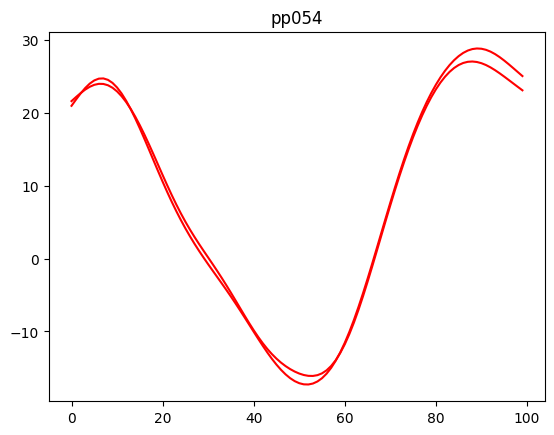

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store average predictions for each patient
y_pred_avg_hip = {}

# Iterate over each patient identifier in subject_list
for pp in subject_list:
    # Calculate the average of all subject predictions for this patient across subjects
    # This computes the mean of the predictions across the values for each subject in y_pred_final_hip[pp]
    y_pred_avg_hip[pp] = np.mean(list(y_pred_final_hip[pp].values()), axis=0)

    # Plot the transposed average prediction (excluding the first row, as [1:, :] skips the first row)
    # The predictions are in red
    plt.plot(np.transpose(y_pred_avg_hip[pp][1:, :]), 'Red')

    # Add a title to the plot with the patient identifier (pp)
    plt.title(pp)

    # Show the plot for this patient
    plt.show()


In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

# List of subjects to process
Subjects = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18']

# Lists to store RMSE values (although not used in this snippet)
Ormse, Onrmse = [], []
Brmse, Bnrmse = [], []

# Dictionary to store predicted values for each patient and subject
y_pred_final_knee = {}

# Define the list of patient identifiers to iterate over
subject_list = ['pp054']

# Iterate over each patient identifier in subject_list
for pp in subject_list:
    y_pred_final_knee[pp] = {}  # Initialize the dictionary for this patient

    # Read the test data for this patient
    x_test_f_1, y_test, subject_test, size_array = read_data(pp, filename='test_knee.pkl')

    # Iterate over each subject (e.g., S01, S02, etc.)
    for Sub in Subjects:
        # Load the trained model for the given subject
        model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Joint-Angle-prediction/Models/Knee/08_03_2024_kneeR_data_model' + Sub + '.h5')

        # Predict using the model
        y_pred = model_1.predict(x_test_f_1)

        # Set filter parameters for signal smoothing
        cutoff = 6  # Cutoff frequency in Hz
        fs = 100    # Sampling frequency in Hz
        order = 4   # Filter order

        # Select the first output channel (e.g., 0:1 means selecting the first column)
        y_pred = y_pred[:, :, 0:1]

        # Combine predictions to match the original sequence dimensions
        y_pred = combine_predictions(y_pred, np.int64(size_array), window_size=40, stride=5, dim=0)

        # Apply a low-pass filter to smooth the predictions
        y_pred = butter_lowpass_filter(y_pred, cutoff, fs, order)

        # Store the processed predictions for this subject
        y_pred_final_knee[pp][Sub] = y_pred


1/1 [==============================] - 4s 4s/step


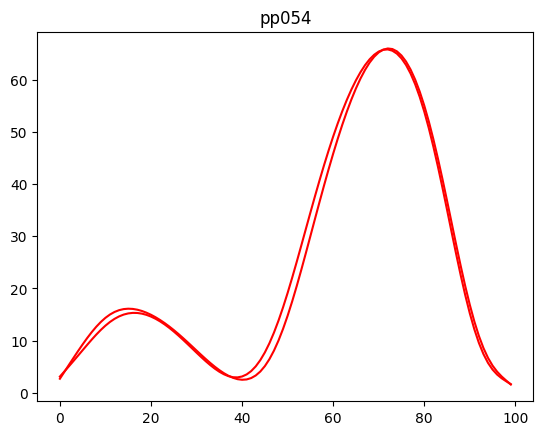

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store average predictions for each patient
y_pred_avg_knee = {}

# Iterate over each patient identifier in subject_list
for pp in subject_list:
    # Calculate the average of all subject predictions for this patient across subjects
    # This computes the mean of the predictions across the values for each subject in y_pred_final_knee[pp]
    y_pred_avg_knee[pp] = np.mean(list(y_pred_final_knee[pp].values()), axis=0)

    # Plot the transposed average prediction (excluding the first row, as [1:, :] skips the first row)
    # The predictions are in red
    plt.plot(np.transpose(y_pred_avg_knee[pp][1:, :]), 'Red')

    # Add a title to the plot with the patient identifier (pp)
    plt.title(pp)

    # Show the plot for this patient
    plt.show()


In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

# List of subjects to process
Subjects = ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18']

# Lists to store RMSE values (although not used in this snippet)
Ormse, Onrmse = [], []
Brmse, Bnrmse = [], []

# Dictionary to store predicted values for each patient and subject
y_pred_final_ankle = {}

# Define the list of patient identifiers to iterate over
subject_list = ['pp054']

# Iterate over each patient identifier in subject_list
for pp in subject_list:
    y_pred_final_ankle[pp] = {}  # Initialize the dictionary for this patient

    # Iterate over each subject (e.g., S01, S02, etc.)
    for Sub in Subjects:
        # Read the test data for this patient
        x_test_f_1, y_test, subject_test, size_array = read_data_ankle(pp, filename='test_ankle.pkl')

        # Load the trained model for the given subject
        model_1 = tf.keras.models.load_model('/content/drive/MyDrive/Joint-Angle-prediction/Models/Ankle/all_08_03_2024_ankleR_data_model' + Sub + '.h5')

        # Predict using the model
        y_pred = model_1.predict(x_test_f_1)

        # Set filter parameters for signal smoothing
        cutoff = 6  # Cutoff frequency in Hz
        fs = 100    # Sampling frequency in Hz
        order = 4   # Filter order

        # Select the first output channel (e.g., 0:1 means selecting the first column)
        y_pred = y_pred[:, :, 0:1]

        # Combine predictions to match the original sequence dimensions
        y_pred = combine_predictions(y_pred, np.int64(size_array), window_size=40, stride=5, dim=0)

        # Apply a low-pass filter to smooth the predictions
        y_pred = butter_lowpass_filter(y_pred, cutoff, fs, order)

        # Store the processed predictions for this subject
        y_pred_final_ankle[pp][Sub] = y_pred


1/1 [==============================] - 4s 4s/step


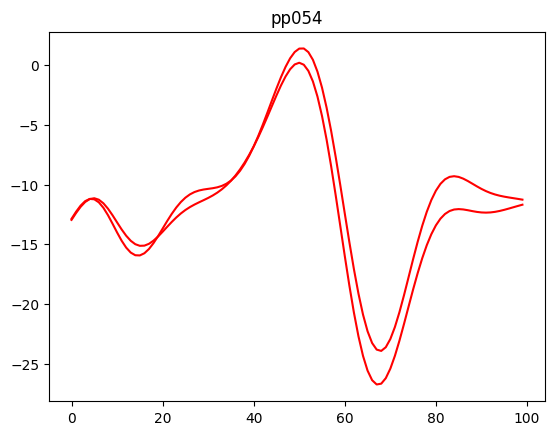

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store average predictions for each patient
y_pred_avg_ankle = {}

# Iterate over each patient identifier in subject_list
for pp in subject_list:
    # Calculate the average of all subject predictions for this patient across subjects
    # This computes the mean of the predictions across the values for each subject in y_pred_final_ankle[pp]
    y_pred_avg_ankle[pp] = np.mean(list(y_pred_final_ankle[pp].values()), axis=0)

    # Plot the transposed average prediction (excluding the first row, as [1:, :] skips the first row)
    # The predictions are in red
    plt.plot(np.transpose(y_pred_avg_ankle[pp][1:, :]), 'Red')

    # Add a title to the plot with the patient identifier (pp)
    plt.title(pp)

    # Show the plot for this patient
    plt.show()


In [25]:
import pandas as pd

# Save the dictionary containing the final knee predictions to a pickle file
# 'y_pred_knee_avg_all.pkl' will store the data for later use or sharing
pd.to_pickle(y_pred_final_knee, 'y_pred_knee_avg_all.pkl')

# Save the dictionary containing the final hip predictions to a pickle file
# 'y_pred_hip_avg_all.pkl' will store the data for later use or sharing
pd.to_pickle(y_pred_final_hip, 'y_pred_hip_avg_all.pkl')

# Save the dictionary containing the final ankle predictions to a pickle file
# 'y_pred_ankle_avg_all.pkl' will store the data for later use or sharing
pd.to_pickle(y_pred_final_ankle, 'y_pred_ankle_avg_all.pkl')


In [26]:
import pandas as pd

# Load the pickled data of OMC data for participant pp054
xdata = pd.read_pickle('/content/drive/MyDrive/Joint-Angle-prediction/OMC_Angle_pp054.pkl')


hip
pp054
3.35
knee
pp054
7.17
ankle
pp054
2.92


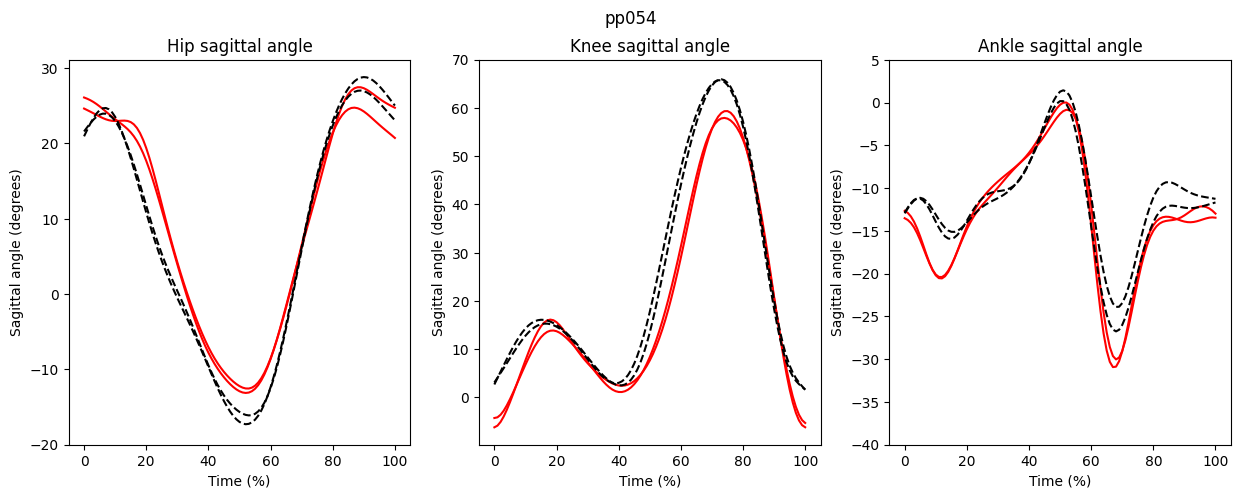

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# List of subjects for processing
subject_list = ['pp054']

# Dictionaries to store averaged predictions for each joint (hip, knee, ankle)
y_pred_avg_hip = {}
y_pred_avg_knee = {}
y_pred_avg_ankle = {}

# DTW condition flag (1 to run with DTW, 0 to run without)
dtw_condition = 0

# Dictionaries to store RMSE values for different conditions
rmse_hip_n = {'walk': {}, 'all': {}}
rmse_knee_n = {'walk': {}, 'all': {}}
rmse_ankle_n = {'walk': {}, 'all': {}}

# Loop over each patient
for pp in subject_list:
    # Initialize a figure for plotting
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(pp)

    # Subplot for Hip
    plt.subplot(1, 3, 1)
    y_pred_avg_hip[pp] = np.mean(list(y_pred_final_hip[pp].values()), axis=0)

    # Get the minimum length for the prediction and ground truth data
    iidx = np.min([y_pred_avg_hip[pp].shape[0] - 1, np.array(xdata[pp]['hip']).shape[0]])

    if iidx > 0:
        # Get the prediction and ground truth data for hip
        x = y_pred_avg_hip[pp][1:iidx + 1]
        y = xdata[pp]['hip'][0:iidx]

        # Normalize the gait data
        x = Normalized_gait(np.array(x))

        # Apply DTW if condition is set to 1
        if dtw_condition == 1:
            x, y = dtw_pred(x, y)

        # Compute RMSE for hip
        rmse1, _ = normalized_rmse(x, y)
        rmse1 = round(rmse1, 2)

        # Store the RMSE in the dictionary
        rmse_hip_n['all'][pp] = rmse1

        # Print RMSE values for hip
        print('hip')
        print(pp)
        print(rmse1)

        # Update the predicted values
        y_pred_avg_hip[pp] = x
        xdata[pp]['hip'] = y

        # Plot the ground truth and predicted hip angles
        plt.plot(np.transpose(y), 'r')
        plt.plot(np.transpose(x), '--k')

        # Title and axis labels
        plt.title('Hip sagittal angle')
        plt.xlabel('Time (%)')
        plt.ylabel('Sagittal angle (degrees)')
        plt.yticks(np.arange(-20, 40, 10))

    # Subplot for Knee
    plt.subplot(1, 3, 2)
    y_pred_avg_knee[pp] = np.mean(list(y_pred_final_knee[pp].values()), axis=0)

    if iidx > 0:
        # Get the prediction and ground truth data for knee
        x = y_pred_avg_knee[pp][1:iidx + 1]
        y = xdata[pp]['knee'][0:iidx]

        # Normalize the gait data
        x = Normalized_gait(np.array(x))

        # Apply DTW if condition is set to 1
        if dtw_condition == 1:
            x, y = dtw_pred(x, y)

        # Compute RMSE for knee
        rmse1, _ = normalized_rmse(x, y)
        rmse1 = round(rmse1, 2)

        # Store the RMSE in the dictionary
        rmse_knee_n['all'][pp] = rmse1

        # Print RMSE values for knee
        print('knee')
        print(pp)
        print(rmse1)

        # Update the predicted values
        y_pred_avg_knee[pp] = x
        xdata[pp]['knee'] = y

        # Plot the ground truth and predicted knee angles
        plt.plot(np.transpose(y), 'r')
        plt.plot(np.transpose(x), '--k')

        # Title and axis labels
        plt.title('Knee sagittal angle')
        plt.xlabel('Time (%)')
        plt.ylabel('Sagittal angle (degrees)')
        plt.yticks(np.arange(0, 80, 10))

    # Subplot for Ankle
    plt.subplot(1, 3, 3)
    y_pred_avg_ankle[pp] = np.mean(list(y_pred_final_ankle[pp].values()), axis=0)

    if iidx > 0:
        # Get the prediction and ground truth data for ankle
        x = y_pred_avg_ankle[pp][1:iidx + 1]
        y = xdata[pp]['ankle'][0:iidx]

        # Normalize the gait data
        x = Normalized_gait(np.array(x))

        # Apply DTW if condition is set to 1
        if dtw_condition == 1:
            x, y = dtw_pred(x, y)

        # Compute RMSE for ankle
        rmse1, _ = normalized_rmse(x, y)
        rmse1 = round(rmse1, 2)

        # Store the RMSE in the dictionary
        rmse_ankle_n['all'][pp] = rmse1

        # Print RMSE values for ankle
        print('ankle')
        print(pp)
        print(rmse1)

        # Update the predicted values
        y_pred_avg_ankle[pp] = x
        xdata[pp]['ankle'] = y

        # Plot the ground truth and predicted ankle angles
        plt.plot(np.transpose(y), 'r')
        plt.plot(np.transpose(x), '--k')

        # Title and axis labels
        plt.title('Ankle sagittal angle')
        plt.xlabel('Time (%)')
        plt.ylabel('Sagittal angle (degrees)')
        plt.yticks(np.arange(-40, 10, 5))

    # Save the plot as .svg and .jpeg files
    plt.savefig('/content/' + pp + '.svg')
    plt.savefig('/content/' + pp + '.jpeg')

    # Show the plot
    plt.show()
